<a href="https://colab.research.google.com/github/mirckrose/machinelearning-week6/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l

     |████████████████████████████████| 83 kB 2.0 MB/s 


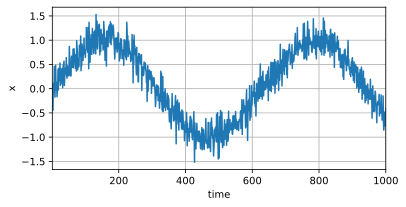

In [2]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l


T = 1000  # Generate a total of 1000 points
time = tf.range(1, T + 1, dtype=tf.float32)
x = tf.sin(0.01 * time) + tf.random.normal([T], 0, 0.2)
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [3]:
tau = 4
features = tf.Variable(tf.zeros((T - tau, tau)))
for i in range(tau):
    features[:, i].assign(x[i:T - tau + i])
labels = tf.reshape(x[tau:], (-1, 1))

batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [4]:
def get_net():
    net = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)])
    return net

# Least mean squares loss
# Note: L2 Loss = 1/2 * MSE Loss. TensorFlow has MSE Loss that is slightly
# different from MXNet's L2Loss by a factor of 2. Hence we halve the loss
# value to get L2Loss in TF
loss = tf.keras.losses.MeanSquaredError()

In [5]:
def train(net, train_iter, loss, epochs, lr):
    trainer = tf.keras.optimizers.Adam()
    for epoch in range(epochs):
        for X, y in train_iter:
            with tf.GradientTape() as g:
                out = net(X)
                l = loss(y, out) / 2
                params = net.trainable_variables
                grads = g.gradient(l, params)
            trainer.apply_gradients(zip(grads, params))
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.390584
epoch 2, loss: 0.148943
epoch 3, loss: 0.086512
epoch 4, loss: 0.075752
epoch 5, loss: 0.073431


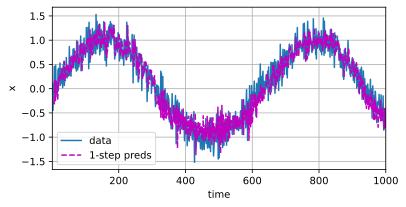

In [6]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.numpy(), onestep_preds.numpy()], 'time', 'x',
         legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

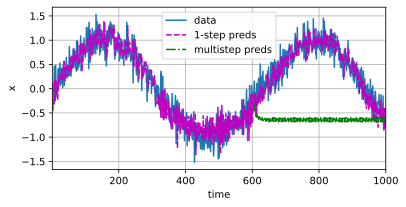

In [7]:
multistep_preds = tf.Variable(tf.zeros(T))
multistep_preds[:n_train + tau].assign(x[:n_train + tau])
for i in range(n_train + tau, T):
    multistep_preds[i].assign(
        tf.reshape(net(tf.reshape(multistep_preds[i - tau:i], (1, -1))), ()))

d2l.plot([time, time[tau:], time[n_train + tau:]], [
    x.numpy(),
    onestep_preds.numpy(), multistep_preds[n_train + tau:].numpy()], 'time',
         'x', legend=['data', '1-step preds',
                      'multistep preds'], xlim=[1, 1000], figsize=(6, 3))

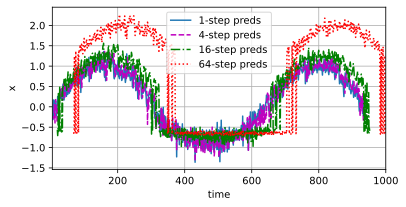

In [8]:
max_steps = 64

features = tf.Variable(tf.zeros((T - tau - max_steps + 1, tau + max_steps)))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i].assign(x[i:i + T - tau - max_steps + 1].numpy())

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i].assign(tf.reshape(net((features[:, i - tau:i])), -1))

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds'
                 for i in steps], xlim=[5, 1000], figsize=(6, 3))

In [9]:
import collections
import re
from d2l import tensorflow as d2l

In [11]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [12]:
def tokenize(lines, token='word'):
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [13]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []

        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)

        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {
            token: idx for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [14]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [15]:
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 2183, 2184, 400]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [16]:
def load_corpus_time_machine(max_tokens=-1):
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

In [17]:
import random
import tensorflow as tf
from d2l import tensorflow as d2l

tokens = d2l.tokenize(d2l.read_time_machine())

corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

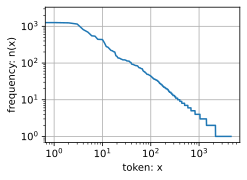

In [18]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)', xscale='log',
         yscale='log')

In [19]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [20]:
trigram_tokens = [
    triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

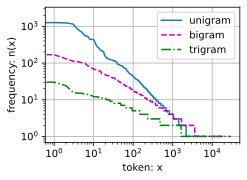

In [21]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

In [22]:
def seq_data_iter_random(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using random sampling."""

    corpus = corpus[random.randint(0, num_steps - 1):]

    num_subseqs = (len(corpus) - 1) // num_steps

    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))

    random.shuffle(initial_indices)

    def data(pos):

        return corpus[pos:pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):

        initial_indices_per_batch = initial_indices[i:i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield tf.constant(X), tf.constant(Y)

In [23]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tf.Tensor(
[[13 14 15 16 17]
 [28 29 30 31 32]], shape=(2, 5), dtype=int32) 
Y: tf.Tensor(
[[14 15 16 17 18]
 [29 30 31 32 33]], shape=(2, 5), dtype=int32)
X:  tf.Tensor(
[[18 19 20 21 22]
 [23 24 25 26 27]], shape=(2, 5), dtype=int32) 
Y: tf.Tensor(
[[19 20 21 22 23]
 [24 25 26 27 28]], shape=(2, 5), dtype=int32)
X:  tf.Tensor(
[[ 3  4  5  6  7]
 [ 8  9 10 11 12]], shape=(2, 5), dtype=int32) 
Y: tf.Tensor(
[[ 4  5  6  7  8]
 [ 9 10 11 12 13]], shape=(2, 5), dtype=int32)


In [24]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using sequential partitioning."""

    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = tf.constant(corpus[offset:offset + num_tokens])
    Ys = tf.constant(corpus[offset + 1:offset + 1 + num_tokens])
    Xs = tf.reshape(Xs, (batch_size, -1))
    Ys = tf.reshape(Ys, (batch_size, -1))
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_batches * num_steps, num_steps):
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X, Y

In [25]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tf.Tensor(
[[ 4  5  6  7  8]
 [19 20 21 22 23]], shape=(2, 5), dtype=int32) 
Y: tf.Tensor(
[[ 5  6  7  8  9]
 [20 21 22 23 24]], shape=(2, 5), dtype=int32)
X:  tf.Tensor(
[[ 9 10 11 12 13]
 [24 25 26 27 28]], shape=(2, 5), dtype=int32) 
Y: tf.Tensor(
[[10 11 12 13 14]
 [25 26 27 28 29]], shape=(2, 5), dtype=int32)
X:  tf.Tensor(
[[14 15 16 17 18]
 [29 30 31 32 33]], shape=(2, 5), dtype=int32) 
Y: tf.Tensor(
[[15 16 17 18 19]
 [30 31 32 33 34]], shape=(2, 5), dtype=int32)


In [26]:
class SeqDataLoader:
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [27]:
def load_data_time_machine(batch_size, num_steps,
                           use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter,
                              max_tokens)
    return data_iter, data_iter.vocab

In [28]:
import tensorflow as tf
from d2l import tensorflow as d2l

X, W_xh = tf.random.normal((3, 1), 0, 1), tf.random.normal((1, 4), 0, 1)
H, W_hh = tf.random.normal((3, 4), 0, 1), tf.random.normal((4, 4), 0, 1)
tf.matmul(X, W_xh) + tf.matmul(H, W_hh)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[ 2.1498232 , -0.80465627, -1.6399884 ,  1.2193824 ],
       [ 7.6783457 , -1.6226544 , -4.4472575 ,  4.346121  ],
       [-3.7014923 ,  1.0613561 ,  1.1566985 , -2.8607268 ]],
      dtype=float32)>

In [29]:
tf.matmul(tf.concat((X, H), 1), tf.concat((W_xh, W_hh), 0))

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[ 2.149823  , -0.80465627, -1.6399885 ,  1.2193824 ],
       [ 7.678345  , -1.6226544 , -4.447258  ,  4.346121  ],
       [-3.7014925 ,  1.0613561 ,  1.1566983 , -2.8607268 ]],
      dtype=float32)>

In [30]:
%matplotlib inline
import math
import tensorflow as tf
from d2l import tensorflow as d2l


batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [31]:
tf.one_hot(tf.constant([0, 2]), len(vocab))

<tf.Tensor: shape=(2, 28), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [32]:
X = tf.reshape(tf.range(10), (2, 5))
tf.one_hot(tf.transpose(X), 28).shape

TensorShape([5, 2, 28])

In [34]:
def get_params(vocab_size, num_hiddens):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return tf.random.normal(shape=shape, stddev=0.01, mean=0,
                                dtype=tf.float32)

    W_xh = tf.Variable(normal((num_inputs, num_hiddens)), dtype=tf.float32)
    W_hh = tf.Variable(normal((num_hiddens, num_hiddens)), dtype=tf.float32)
    b_h = tf.Variable(tf.zeros(num_hiddens), dtype=tf.float32)

    W_hq = tf.Variable(normal((num_hiddens, num_outputs)), dtype=tf.float32)
    b_q = tf.Variable(tf.zeros(num_outputs), dtype=tf.float32)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    return params

In [35]:
def init_rnn_state(batch_size, num_hiddens):
    return (tf.zeros((batch_size, num_hiddens)),)

In [36]:
def rnn(inputs, state, params):

    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []

    for X in inputs:
        X = tf.reshape(X, [-1, W_xh.shape[0]])
        H = tf.tanh(tf.matmul(X, W_xh) + tf.matmul(H, W_hh) + b_h)
        Y = tf.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return tf.concat(outputs, axis=0), (H,)

In [37]:
class RNNModelScratch:
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, init_state, forward_fn,
                 get_params):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.init_state, self.forward_fn = init_state, forward_fn
        self.trainable_variables = get_params(vocab_size, num_hiddens)

    def __call__(self, X, state):
        X = tf.one_hot(tf.transpose(X), self.vocab_size)
        X = tf.cast(X, tf.float32)
        return self.forward_fn(X, state, self.trainable_variables)

    def begin_state(self, batch_size, *args, **kwargs):
        return self.init_state(batch_size, self.num_hiddens)

In [38]:
device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)

num_hiddens = 512
with strategy.scope():
    net = RNNModelScratch(len(vocab), num_hiddens, init_rnn_state, rnn,
                          get_params)
state = net.begin_state(X.shape[0])
Y, new_state = net(X, state)
Y.shape, len(new_state), new_state[0].shape

(TensorShape([10, 28]), 1, TensorShape([2, 512]))

In [39]:
def predict_ch8(prefix, num_preds, net, vocab):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, dtype=tf.float32)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: tf.reshape(tf.constant([outputs[-1]]), (1, 1)).numpy()
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.numpy().argmax(axis=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [40]:
predict_ch8('time traveller ', 10, net, vocab)

'time traveller w opssmzw '

In [41]:
def grad_clipping(grads, theta):
    """Clip the gradient."""
    theta = tf.constant(theta, dtype=tf.float32)
    new_grad = []
    for grad in grads:
        if isinstance(grad, tf.IndexedSlices):
            new_grad.append(tf.convert_to_tensor(grad))
        else:
            new_grad.append(grad)
    norm = tf.math.sqrt(
        sum((tf.reduce_sum(grad**2)).numpy() for grad in new_grad))
    norm = tf.cast(norm, tf.float32)
    if tf.greater(norm, theta):
        for i, grad in enumerate(new_grad):
            new_grad[i] = grad * theta / norm
    else:
        new_grad = new_grad
    return new_grad

In [42]:
def train_epoch_ch8(net, train_iter, loss, updater, use_random_iter):
    """Train a model within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:

            state = net.begin_state(batch_size=X.shape[0], dtype=tf.float32)
        with tf.GradientTape(persistent=True) as g:
            y_hat, state = net(X, state)
            y = tf.reshape(tf.transpose(Y), (-1))
            l = loss(y, y_hat)
        params = net.trainable_variables
        grads = g.gradient(l, params)
        grads = grad_clipping(grads, 1)
        updater.apply_gradients(zip(grads, params))

        metric.add(l * tf.size(y).numpy(), tf.size(y).numpy())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [43]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, strategy,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    with strategy.scope():
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        updater = tf.keras.optimizers.SGD(lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab)

    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    device = d2l.try_gpu()._device_name
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

perplexity 1.1, 7279.3 tokens/sec on /CPU:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


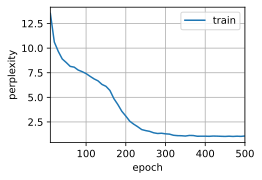

In [44]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, strategy)

perplexity 1.4, 7447.5 tokens/sec on /CPU:0
time travellerit s against reason said filbywhat space they laug
travellerit s against reason said filbywhat space they laug


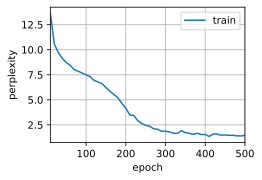

In [46]:
with strategy.scope():
    net = RNNModelScratch(len(vocab), num_hiddens, init_rnn_state, rnn,
                          get_params)
train_ch8(net, train_iter, vocab, lr, num_epochs, strategy,
          use_random_iter=True)